In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:

import re

def parse_prediction(predicted_text_list,unit_list):

    pred_list=[]

    for i in range(len(predicted_text_list)):
        text=predicted_text_list[i]
        unit=unit_list[i]


        #正規表現で､「数値」 + unitを抽出｡数値は小数点やマイナスも含む｡unitの前にスペースがある場合もない場合もある
        #unit_pattern = re.escape(unit).replace(r'\[', r'\[?').replace(r'\]', r'\]?')
        #pattern = rf"-?\d+(\.\d+)?\s*{unit_pattern}"
        # 正規表現によるマッチング
        #match = re.search(pattern, text)

        # 正規表現パターンを定義: "is" の後に数値部分 (-?(\d+(\.\d+)?))
        pattern = r"is\s*(-?\d+(\.\d+)?)"

        # 正規表現によるマッチング
        match = re.search(pattern, text)
        if match:
            predict=(match.group())
            #predict=predict.replace(unit,"").strip()
            #predict=predict.replace(unit[1:-1],"").strip()
            predict=predict.replace("is ","").strip()
            pred_list.append(float(predict))
        else:
            pred_list.append(None)

    return pred_list

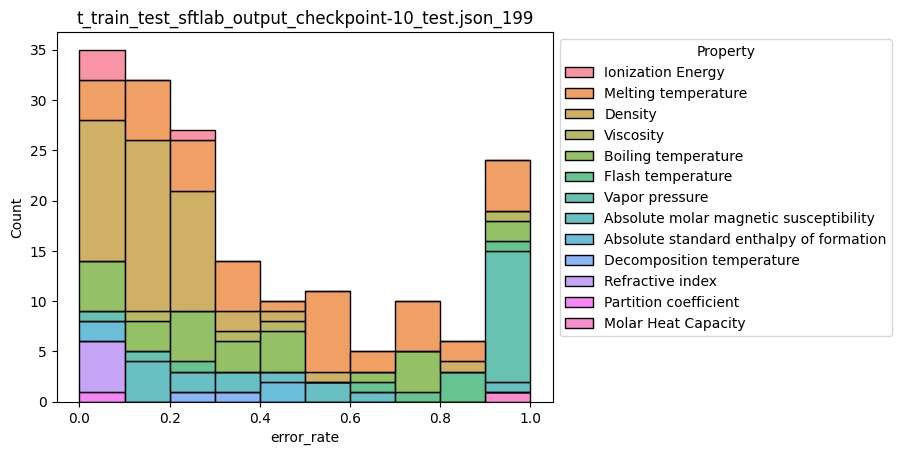

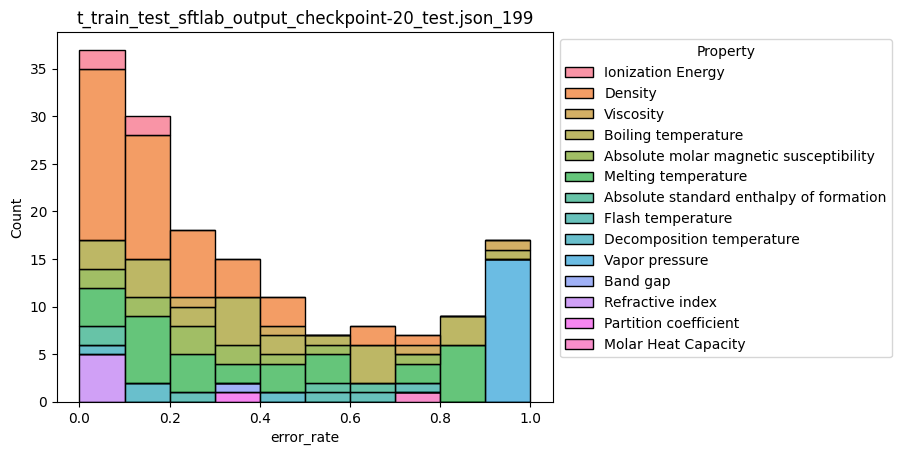

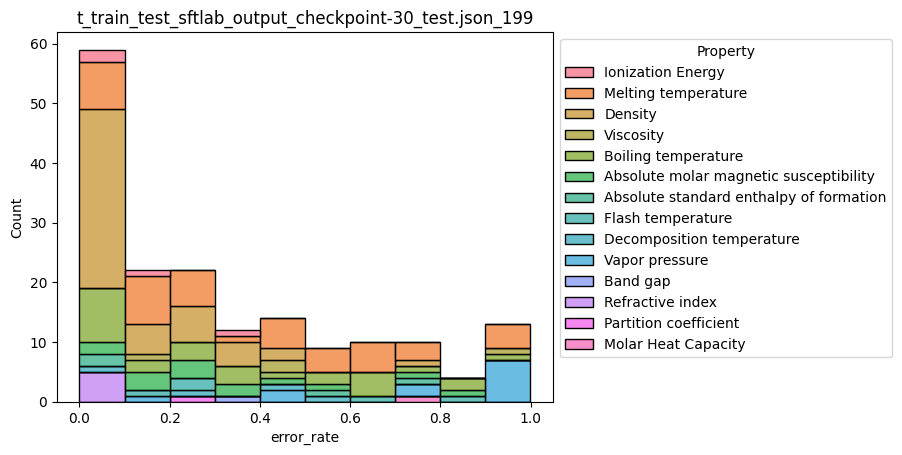

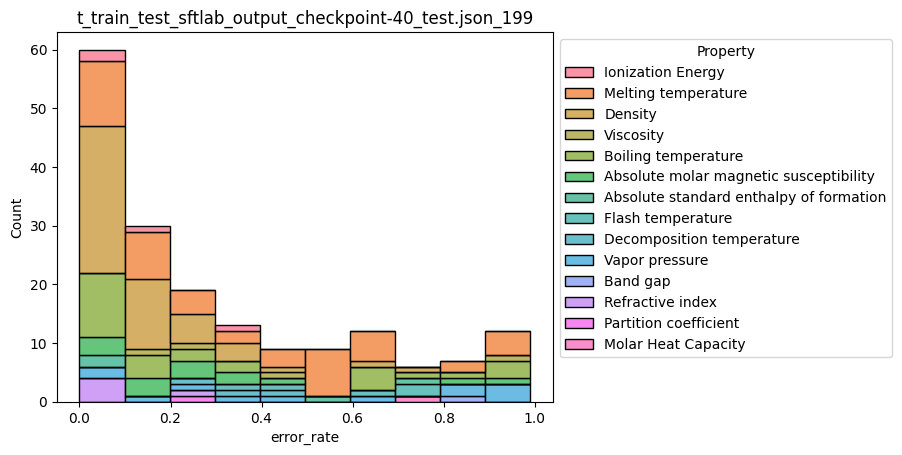

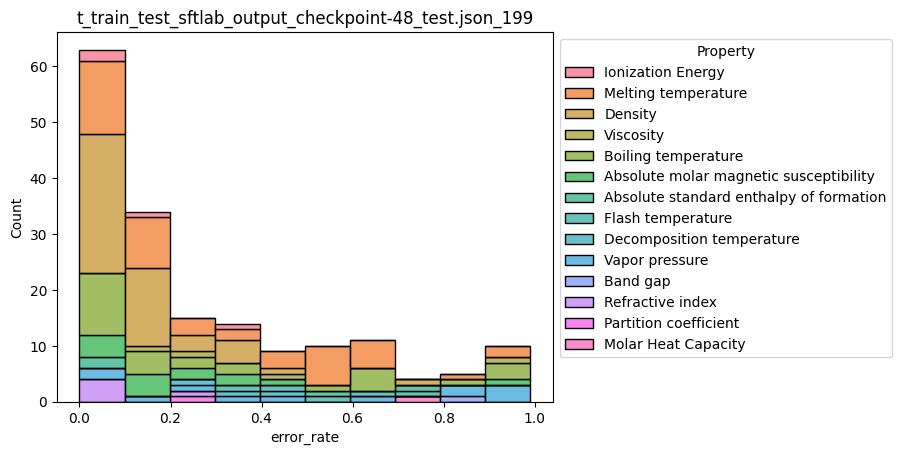

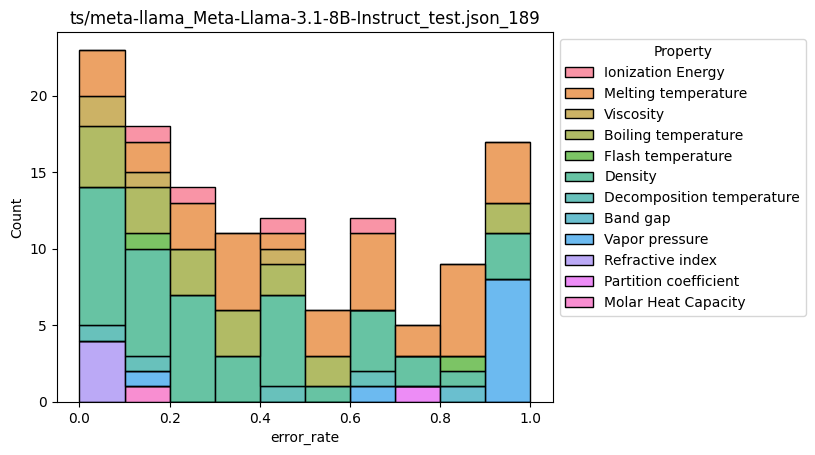

In [3]:
import glob
json_list=glob.glob("eval_results/*.json")

json_list+=glob.glob("/data/hatakeyama/self-loop/0920evaluate_prediction_accuracy/eval_results/*.json")

mode="test"

error_rate_dict={}

json_list.sort()

for target_json in json_list:

    if target_json.find(mode)==-1:
        continue

    df=pd.read_json(target_json)
    #predicted_valueをfloatに変更｡変換できないものはNaNにする
    df["predicted_value_float"] = pd.to_numeric(df["predicted_value"], errors='coerce')

    if target_json.find("meta")==-1:
        predicted_text_list=df["predicted_text"].tolist()
        unit_list=df["unit"].tolist()
        predicted_value_list=parse_prediction(predicted_text_list,unit_list)
        df["predicted_value_float"]=predicted_value_list


    #actual_value, predicted_valueの誤差率を計算(絶対値を取る
    df["error_rate"]=(df["Value"]-df["predicted_value_float"])/df["Value"]
    df["error_rate"]=df["error_rate"].abs()

    #誤差率が0以上のものを抽出
    sel_df=df[df["error_rate"]>=0]
    sel_df["predicted_text"].tolist()

    #plt.figure()
    #plt.title(target_json)
    #sns.boxplot(x="error_rate",y="Property",data=sel_df)
    #plt.xlim(-1,2)
    #xはlog
    #plt.xscale("log")
    #x=0.1に縦線を引く
    #plt.axvline(x=0.1, color='r', linestyle='--')

    plt.figure()
    plt.title(target_json[-50:]+"_"+str(sel_df.shape[0]))
    #sns.histplot(data=sel_df,x="error_rate",bins=100,hue="Property")
    ax=sns.histplot(data=sel_df[sel_df["error_rate"]<1],x="error_rate",
                 bins=10,hue="Property",
                multiple="stack"
                 )
    #plt.xlim(0,1)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    error_rate_dict[target_json]=sel_df["error_rate"].median()

In [4]:
error_rate_df=pd.DataFrame(error_rate_dict.items(),columns=["json","median_error_rate"])

<Axes: xlabel='step', ylabel='median_error_rate'>

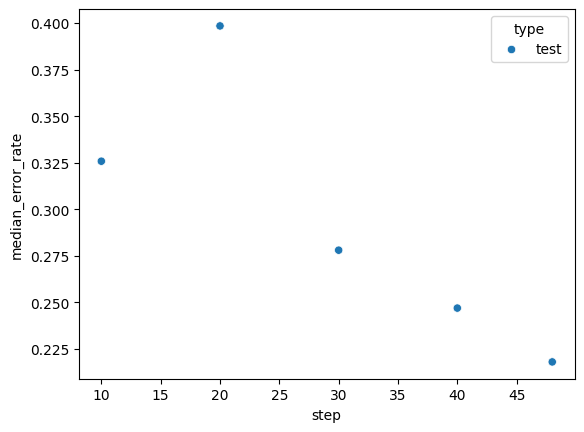

In [5]:
error_rate_df["temp"]=error_rate_df["json"].str.split("checkpoint-").str[-1].str.split(".").str[0]
error_rate_df["step"]=error_rate_df["temp"].str.split("_").str[0]
error_rate_df["step"] = pd.to_numeric(error_rate_df["step"], errors='coerce')
error_rate_df["type"]=error_rate_df["temp"].str.split("_").str[1]
sns.scatterplot(data=error_rate_df[error_rate_df["type"]=="test"],x="step",y="median_error_rate",hue="type")

In [98]:
sel_df["error_rate"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
6983    0.0
6984    0.0
6987    0.0
6988    0.0
6998    0.0
Name: error_rate, Length: 5655, dtype: float64